# **Insurance Cross-Selling**

**`AssurePredict`** is a leading insurance company specializing in innovative risk management solutions. This project aims to create a predictive model capable of identifying potential cross-selling opportunities for existing customers, identifying those who may be interested in purchasing additional vehicle insurance.

`Project Objective:`

The goal is to develop a machine learning model that predicts whether customers who currently have health insurance might be interested in purchasing additional vehicle insurance. The model will help AssurePredict improve the effectiveness of its cross-selling strategies and increase market penetration.

`Added value for AssurePredict:`

Increased conversion rate for auto insurance sales.
Optimized marketing campaigns by targeting offers to customers most likely to purchase.
Reduced costs associated with ineffective marketing campaigns, thanks to precise targeting.



---



## *Exploratory data analysis*

In [ ]:
# import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score
from imblearn.over_sampling import SMOTE

RANDOM_SEED = 42 # seed for reproducibility

In [ ]:
# import the dataset
BASE_URL = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv'
df = pd.read_csv(BASE_URL)
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
df.shape

(381109, 12)

The dataset is composed of 381109 rows and 12 columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


The dataset:
- `id`: unique customer identifier.
- `Gender`: customer's gender.
- `Age`: customer's age.
- `Driving_License`: 1 if the customer has a driver's license, 0 otherwise.
- `Region_Code`: unique code for the customer's region of residence.
- `Previously_Insured`: 1 if the customer already has an insured vehicle, 0 otherwise.
- `Vehicle_Age`: age of the customer's vehicle.
- `Vehicle_Damage`: 1 if the customer has had accidents or damage to the vehicle in the past, 0 otherwise.
- `Annual_Premium`: annual amount of the insurance premium paid by the customer.
- `PolicySalesChannel`: channel used to sell the policy (e.g., email, phone, in person).
- `Vintage`: days since the customer has been insured with AssurePredict.
- `Response`: 1 if the customer accepted the cross-sell proposal, 0 otherwise.

In [ ]:
duplicated_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicated_rows}")

Number of duplicate rows: 0


In [ ]:
df.drop_duplicates(inplace=True) # remove duplicates

In [ ]:
print(f"After cleaning, duplicate rows are: {df.duplicated().sum()}")

After cleaning, duplicate rows are: 0


In [ ]:
null = df.isnull().sum()
print(f"Number of null rows:\n{null}")

Number of null rows:
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64


there are no null values

In [ ]:
print(df['Response'].value_counts())
print(df['Response'].value_counts(normalize=True)*100)

Response
0    334399
1     46710
Name: count, dtype: int64
Response
0    87.743664
1    12.256336
Name: proportion, dtype: float64


The classes are unbalanced, 87% of cases are in class 0 and only 12% are in class 1.

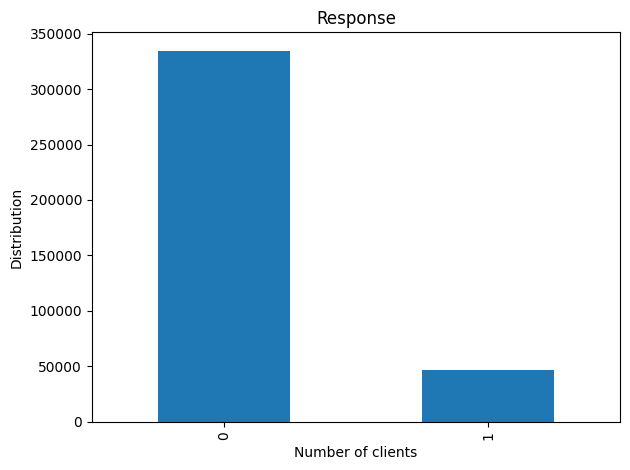

In [ ]:
df['Response'].value_counts().plot(kind='bar')
plt.title('Response')
plt.xlabel('Number of clients')
plt.ylabel('Distribution')
plt.tight_layout()
plt.show()

Most customers did not accept the cross-sell proposal

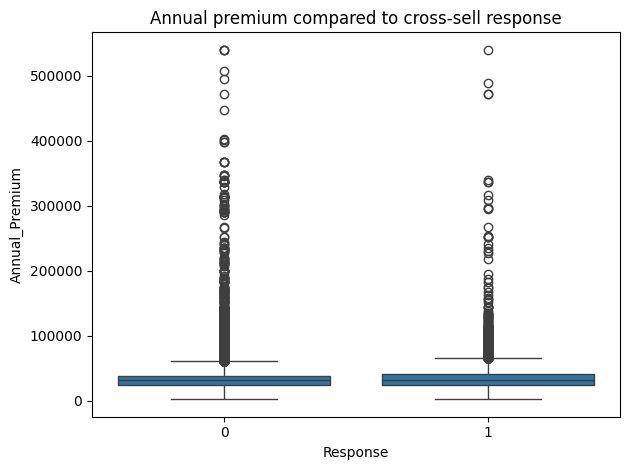

In [ ]:
# boxplot
sns.boxplot(x='Response', y='Annual_Premium', data=df)
plt.title("Annual premium compared to cross-sell response")
plt.tight_layout()
plt.show()

The annual premium does not appear to be a decisive factor in predicting whether or not a customer will respond to the cross-sell offer.

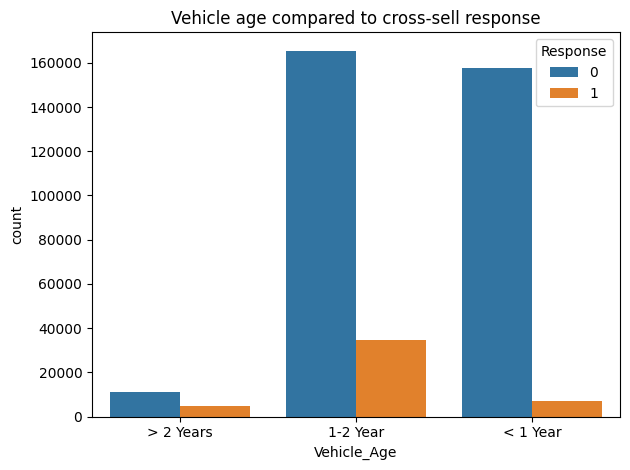

In [ ]:
# vehicle_age
sns.countplot(x='Vehicle_Age', hue='Response', data=df)
plt.title("Vehicle age compared to cross-sell response")
plt.tight_layout()
plt.show()

- Customers with new cars ("< 1 year") are the
least interested in the offer.

- Customers with older cars ("> 2 years") are, proportionally, the most likely to accept.

- Customers with cars that are 1-2 years old are somewhere in between.

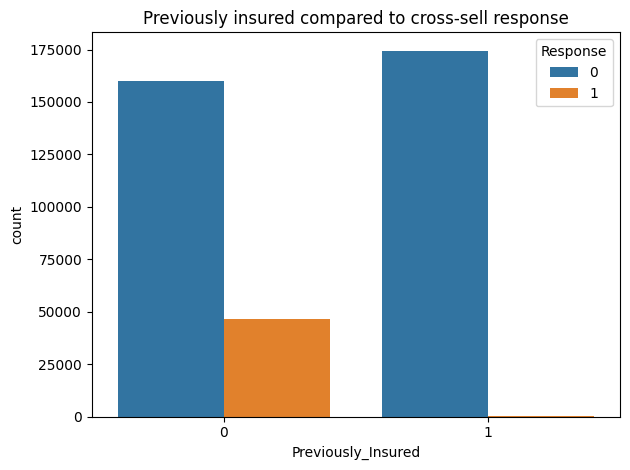

In [ ]:
# previously_insured
sns.countplot(x='Previously_Insured', hue='Response', data=df)
plt.title("Previously insured compared to cross-sell response")
plt.tight_layout()
plt.show()

It appears that the cross-selling offer is effective almost exclusively on customers who were not previously insured (Group 0). Customers who were already insured (Group 1) are almost never interested.

## *Preprocessing*

In [ ]:
df.drop('id', axis=1,inplace=True)
# dropping the id column as it's just an identifier and not useful for analysis

Applied Label Encoding to the Gender and Vehicle_Damage variables to convert the text values ​​to numeric values.

In [ ]:
gender_encoder = LabelEncoder()
df['Gender'] = gender_encoder.fit_transform(df['Gender']) # 1=M / 0=F

In [ ]:
vehichle_damage_encoder = LabelEncoder()
df['Vehicle_Damage'] = vehichle_damage_encoder.fit_transform(df['Vehicle_Damage']) # Y=1 / 0=N

For vehicle_age I don't use the label encoder because there is no logical order between the labels, I use map

In [ ]:
mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
df['Vehicle_Age'] = df['Vehicle_Age'].map(mapping)

In [ ]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,0,29,1,41.0,1,0,0,27496.0,152.0,39,0


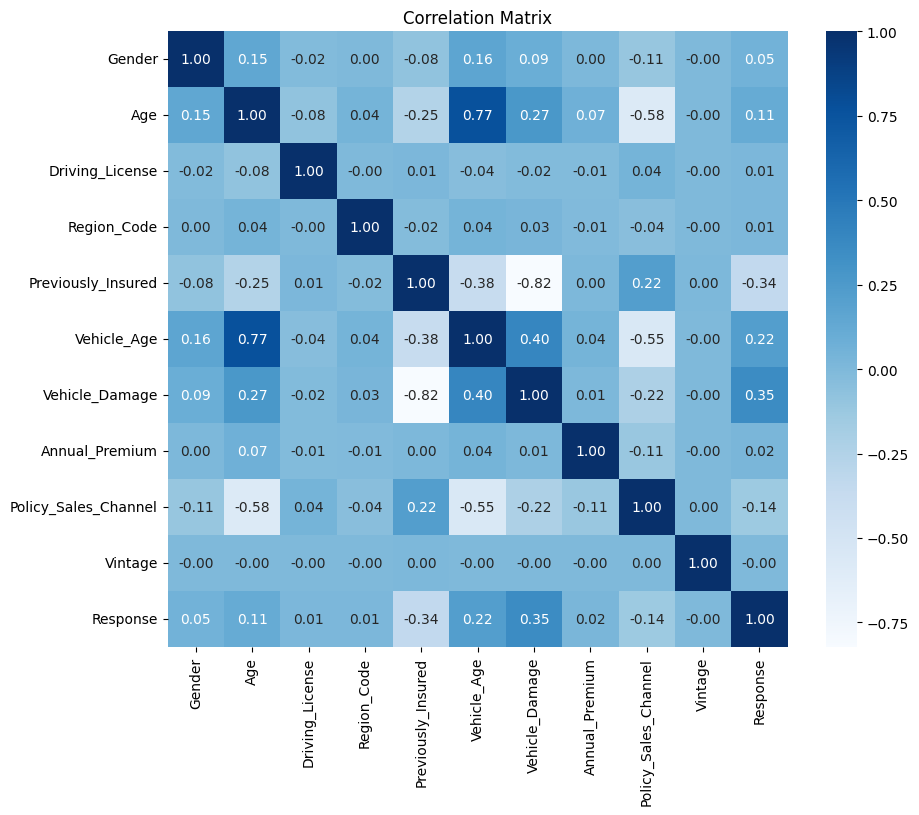

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

The matrix shows few strong correlations between the independent variables and the target.

In [ ]:
X = df.drop('Response', axis=1)
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

## `MODEL`: **LOGISTIC REGRESSION**


I used a Logistic Regression model inserted into a pipeline with StandardScaler and SMOTE.
StandardScaler normalizes the numeric variables, while SMOTE balances the target variable Response, which is unbalanced.
The model was trained with max_iter=500 and class_weight='balanced' to better handle the two classes.

In [ ]:
pipeline_lr = ImbPipeline([
    ('scaler', StandardScaler()), # Standardize
    ('smote', SMOTE(random_state=RANDOM_SEED)), # Balance classes with oversampling
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced',random_state=RANDOM_SEED))
])

In [ ]:
pipeline_lr.fit(X_train, y_train)
y_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]

threshold = 0.7
y_pred_lr = (y_proba_lr >= threshold).astype(int)

print('Classification Report:')
print(classification_report(y_test, y_pred_lr))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_lr))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     66880
           1       0.32      0.62      0.42      9342

    accuracy                           0.79     76222
   macro avg       0.63      0.72      0.65     76222
weighted avg       0.86      0.79      0.82     76222

Confusion Matrix:
[[54530 12350]
 [ 3528  5814]]


The model identifies class 0 (not interested) well, but struggles with class 1 (interested), with low precision and F1 scores. The overall accuracy is 0.79.

In [ ]:
best_f1 = 0
best_threshold = 0
for threshold in np.arange(0.4, 0.86, 0.01):
    preds = (y_proba_lr > threshold).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
print(f"Best threshold: {best_threshold:.2f}\nF1 score: {best_f1:.3f}")

Best threshold: 0.66
F1 score: 0.435


The optimal threshold found is 0.65, which maximizes the F1 score to 0.416.

/tmp/ipython-input-2742912749.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='grey')


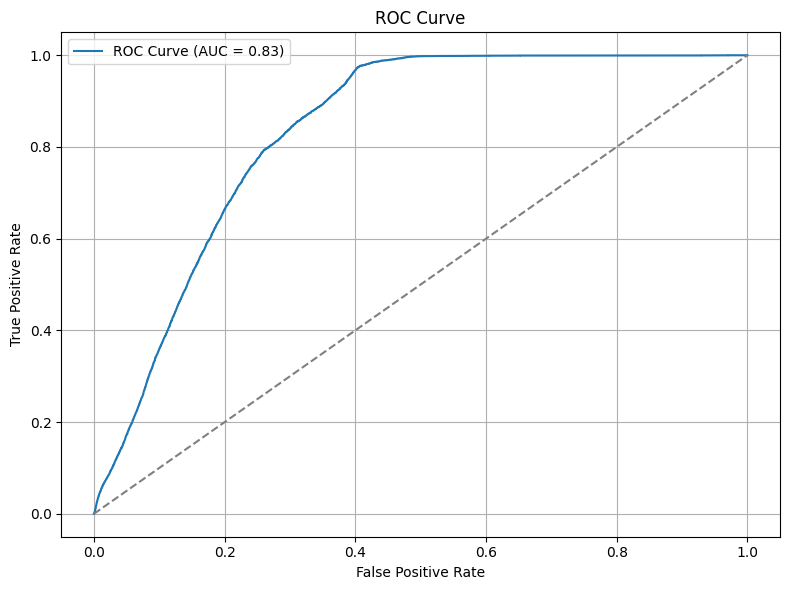

In [ ]:
# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

The results show an AUC of 0.82, so the model distinguishes well between interested and uninterested customers.

In [ ]:
#  saving the results
y_pred_lr_end = (y_proba_lr >= best_threshold).astype(int)

results = pd.DataFrame({'y_true': y_test, 'y_proba': y_proba_lr, 'y_pred': y_pred_lr_end})
results.to_csv('final_results.csv', index=False)
print("Results saved in 'final_results.csv'")

Results saved in 'final_results.csv'


## *Conclusion*

In this project, I performed the main exploratory analysis and data preprocessing phases, removing duplicates and the id column, analyzing the target distribution, and applying Label Encoding to the categorical variables (*Gender, Vehicle_Age, Vehicle_Damage*).

I subsequently trained a Logistic Regression model integrated into a pipeline with StandardScaler for normalization and SMOTE for class balancing, given the strong prevalence of class 0 (87%) over class 1 (12%).

The model achieved satisfactory results, with an accuracy of 79% and an AUC of 0.82.


---

The model demonstrates good ability in discriminating uninterested clients, as shown by the high specificity and overall AUC. However, like most models dealing with unbalanced data, it struggles to identify all interested clients (class 1), resulting in lower recall and F1 score for this class.